In [20]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('data/Stress-Lysis.csv')
display(df)

,Humidity,Temperature,Step_count,Stress_Level
0,21.33,90.33,123,mid
1,21.41,90.41,93,mid
2,27.12,96.12,196,high
3,27.64,96.64,177,high
4,10.87,79.87,87,low
...,...,...,...,...
1996,21.82,90.82,96,mid
1997,10.45,79.45,45,low
1998,27.22,96.22,135,high
1999,12.46,81.46,64,low


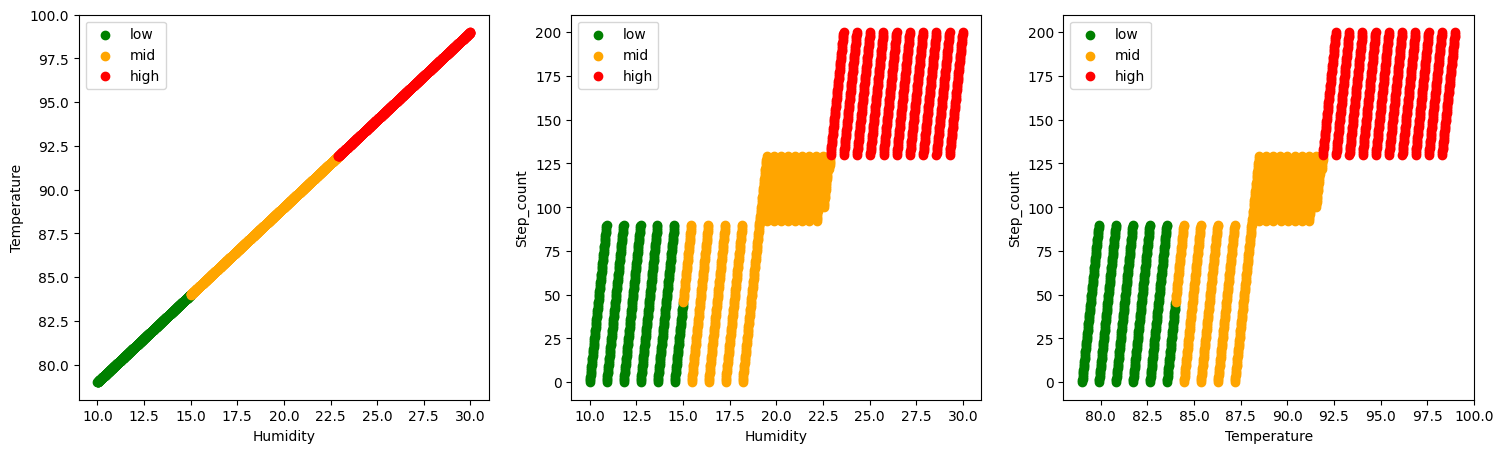

In [21]:
count = len(list(itertools.combinations(df.columns[:-1], 2)))

fig = plt.figure(figsize=(6*count, 5))

for idx, (c1, c2) in enumerate(itertools.combinations(df.columns[:-1], 2)):
    ax = plt.subplot(1, count, idx+1)

    low_df = df.loc[df['Stress_Level'] == 'low']
    mid_df = df.loc[df['Stress_Level'] == 'mid']
    high_df = df.loc[df['Stress_Level'] == 'high']

    ax.set_xlabel(c1)
    ax.set_ylabel(c2)

    ax.scatter(low_df[c1], low_df[c2], color='green' , label='low')
    ax.scatter(mid_df[c1], mid_df[c2], color='orange', label='mid')
    ax.scatter(high_df[c1], high_df[c2], color='red', label='high')

    ax.legend()

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')



# randomly split data into three part (train, test, validation) w.r.t input ratio
def split_train_valid_test(X, y, test_ratio):
    np.random.seed(123)
    shuffled_indcies = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_ratio)
    train_indices = shuffled_indcies[test_set_size:]
    test_indcies = shuffled_indcies[:test_set_size]
    return X[train_indices], y[train_indices], X[test_indcies], y[test_indcies]



# calculate confusion matrix according to output of classifier and actual label
def gen_conf_mat(actual, predicted, classes):
    matrix = np.zeros((len(classes), len(classes))) # initialize the confusion matrix with zeros

    for i in range(len(classes)):
        for j in range(len(classes)):
            matrix[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return matrix



def cal_f1_score(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)

    f1_score = 2 * (PPV * TPR) / (PPV + TPR)
    return f1_score



def cal_jaccard(cm):
    numerator = np.diag(cm)
    denominator = np.sum(cm, axis=0) + np.sum(cm, axis=1) - np.diag(cm)
    return numerator / denominator

In [23]:
feature_list = ['Humidity', 'Temperature']

X = df[feature_list].to_numpy()
y = df[['Stress_Level']].to_numpy()
classes = np.unique(y)

X_train, y_train, X_test, y_test = split_train_valid_test(X, y, test_ratio = 0.2)

print(X_train.shape, X_test.shape)

(1601, 2) (400, 2)


In [24]:
max = np.max(X_train, axis=0)
min = np.min(X_train, axis=0)

X_train = (X_train - min) / (max - min)
X_test = (X_test - min) / (max - min)

In [25]:
level_to_int = dict((l, i) for i, l in enumerate(classes))
int_to_level = dict((i, c) for i, c in enumerate(classes))

def one_hot_encoder(y):
    y_oh = np.zeros((len(y), len(classes)))
    for i, v in enumerate(y):
        y_oh[i][level_to_int[v]] = 1
    return y_oh

y_train_oh = one_hot_encoder(y_train.flatten())
y_test_oh = one_hot_encoder(y_train.flatten())

In [26]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

X_train_b = np.c_[np.ones((len(X_train), 1)), X_train]  # add x0 = 1 to each instance
# X_train_b = X_train

eta = 0.5  # learning rate
l2 = 1.0
n_iterations = 2500

np.random.seed(123)
theta = np.random.randn(X_train_b.shape[1], y_train_oh.shape[1])  # random initialization

for iteration in range(n_iterations):
    gradients = X_train_b.T.dot(softmax(X_train_b.dot(theta)) - y_train_oh) + l2*theta
    theta = theta - eta * (1/len(X_train_b))*gradients

X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]  # add x0 = 1 to each instance
y_pred = np.array([int_to_level[v] for v in np.argmax(X_test_b.dot(theta), axis=1)]).reshape(-1, 1)

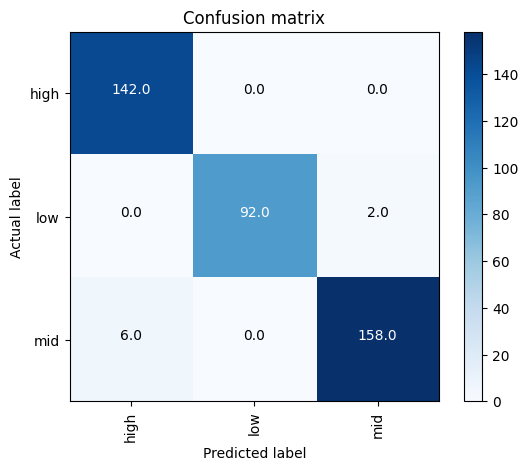

In [27]:
cm = gen_conf_mat(y_test, y_pred, classes)

plot_confusion_matrix(cm, classes)

In [28]:
jaccards = cal_jaccard(cm)
print('Jaccard Similarity(class low): %.2f' % jaccards[0])
print('Jaccard Similarity(class mid): %.2f' % jaccards[1])
print('Jaccard Similarity(class high): %.2f' % jaccards[2])


f1_scores = cal_f1_score(cm)
print('F1-Score(class low): %.2f' % f1_scores[0])
print('F1-Score(class mid): %.2f' % f1_scores[1])
print('F1-Score(class high): %.2f' % f1_scores[2])

Jaccard Similarity(class low): 0.96
Jaccard Similarity(class mid): 0.98
Jaccard Similarity(class high): 0.95
F1-Score(class low): 0.98
F1-Score(class mid): 0.99
F1-Score(class high): 0.98


In [29]:
from sklearn.model_selection import train_test_split

feature_list = ['Humidity', 'Temperature']

X = df[feature_list].to_numpy()
y = df[['Stress_Level']].to_numpy()
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [30]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaling
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.flatten()
y_test = y_test.flatten()

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_train)

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(y_train_int.reshape(-1, 1))
y_train_oh = onehot_encoder.transform(y_train_int.reshape(-1, 1))
y_test_oh = onehot_encoder.transform(y_test_int.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=123)
clf.fit(X_train, y_train.flatten())

y_pred = clf.predict(X_test)

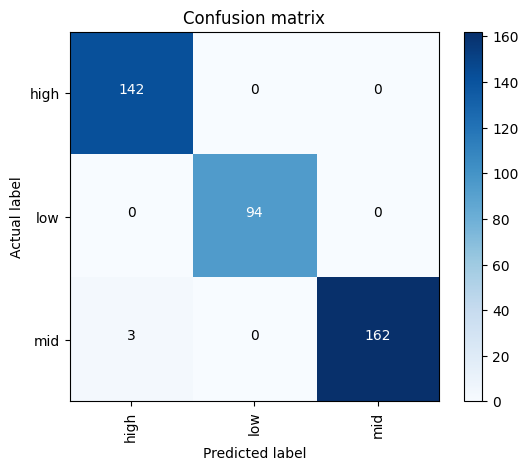

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes)

In [34]:
from sklearn.metrics import jaccard_score

jaccards = jaccard_score(y_test, y_pred, average=None)
print('Jaccard Similarity(class low): %.2f' % jaccards[0])
print('Jaccard Similarity(class mid): %.2f' % jaccards[1])
print('Jaccard Similarity(class high): %.2f' % jaccards[2])



from sklearn.metrics import f1_score

f1_scores = f1_score(y_test, y_pred, average=None)
print('F1-Score(class low): %.2f' % f1_scores[0])
print('F1-Score(class mid): %.2f' % f1_scores[1])
print('F1-Score(class high): %.2f' % f1_scores[2])

Jaccard Similarity(class low): 0.98
Jaccard Similarity(class mid): 1.00
Jaccard Similarity(class high): 0.98
F1-Score(class low): 0.99
F1-Score(class mid): 1.00
F1-Score(class high): 0.99


In [35]:
from sklearn.metrics import roc_curve, auc

y_pred_oh = one_hot_encoder(y_pred)
y_test_oh = one_hot_encoder(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_pred_oh[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

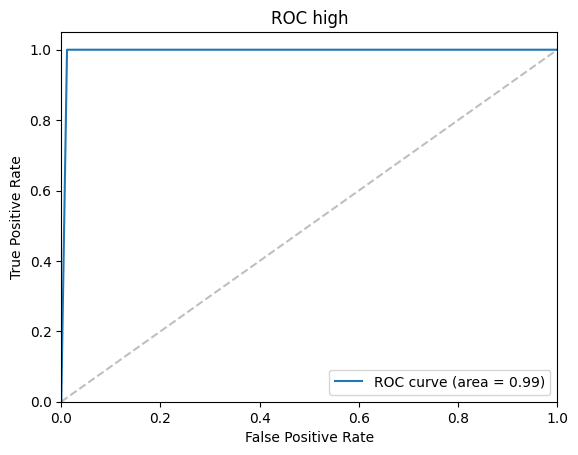

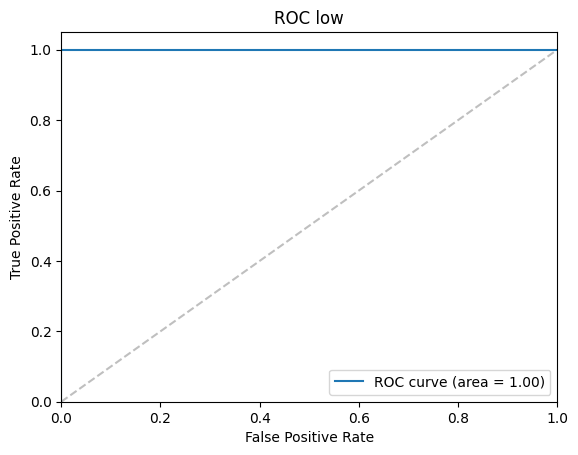

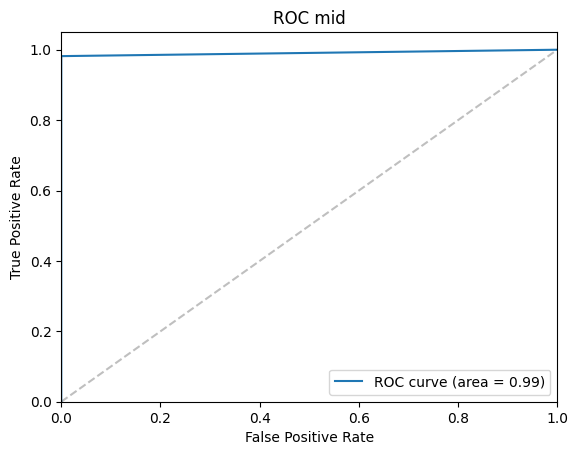

In [36]:
# Plot of a ROC curve for a specific class
for i in range(len(classes)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC %s' % classes[i])
    plt.legend(loc="lower right")
    plt.show()